In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, GridSearchCV, LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import shap
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Machine learning/data/final_spotify_tracks.csv')
data.set_index('title', inplace=True)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,POP,3.693075,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,Eminem,HIPHOP,44.814807,94.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,Kesha,POP,6.410236,81.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,Lady Gaga,POP,17.680180,89.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,Bruno Mars,POP,31.020064,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


Encoding the nominal variables, since no algorithm can work with them expressed as string values.

In [4]:
enc = LabelEncoder()
data['artist'] = enc.fit_transform(data['artist'])
data['top genre'] = enc.fit_transform(data['top genre'])
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,4,3.693075,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,58,3,44.814807,94.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,103,4,6.410236,81.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,108,4,17.680180,89.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,26,4,31.020064,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


Scaling the data for the neural networks, doesn't make a difference for xgboost.

In [5]:
labels = ['track_popularity']
features = data.columns.drop(labels)
X = data[features]
Y = data[labels]

scaler = StandardScaler()
X[X.columns.drop(['artist', 'top genre', 'year'])] = scaler.fit_transform(X[X.columns.drop(['artist', 'top genre', 'year'])])
X.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness
title,,,,,,,,,,,,,,
"Hey, Soul Sister",200,4,-0.821961,-0.751926,2010,-0.894579,1.180111,0.148635,0.872966,-0.737832,1.227401,-0.166341,0.176541,-0.589843
Love The Way You Lie,58,3,1.701562,1.250110,2010,-1.304649,1.426971,0.754609,0.307914,2.526270,0.511658,1.158459,0.409739,1.803688
TiK ToK,103,4,-0.655216,-0.376544,2010,0.048585,0.871535,0.830356,1.438017,0.820035,0.824796,-0.655940,-0.243214,0.669910
Bad Romance,108,4,0.036388,0.624474,2010,0.007577,1.365256,0.375876,0.872966,-0.737832,0.824796,2.080059,-0.709610,-0.589843
Just the Way You Are,26,4,0.855018,1.124983,2010,-0.402493,0.871535,-0.078605,0.307914,-0.663648,-0.427754,-0.051141,-0.616331,-0.589843


In [6]:
X = X.fillna(X.median())

Fill missing valiues with their median since their distributions are skewed.

Define a function that performs leave one out cross validation for regression.

In [7]:
def cross_validation_regression(X, Y, model): #cross validation prediction, leave one out
  predicted = []
  actual = []
  folds = LeaveOneOut()

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(list(Y_test.values))

  return predicted, actual

Define a function that draws the prediction against the targets, sorted by the error in increasing rate.

In [8]:
def draw_error_distribution(errors, predictions, actual):
  ordered_values = []
  for i in range(len(errors)):
    node = {}
    node['predicted'] = predictions[i]
    node['actual'] = actual[i]
    node['error'] = errors[i]
    ordered_values.append(node)
  ordered_values.sort(key = lambda item: item['error'])
  x = np.arange(1, len(errors) + 1)
  plt.figure(figsize=(40, 15))
  for i, elem in enumerate(ordered_values):
    plt.bar(x[i]-0.5, elem['actual'], width=0.5, color='orange', align='center', label='True values')
    plt.bar(x[i], elem['predicted'], color='blue', label='Predicted values', width = 0.5, align='center')
  plt.legend(['Actual', 'Predicted'])
  plt.title('Predictions vs Actual values')

A function that performs hyper parameter search with inner 5-fold cross validation and optimizes mean absolute error.

In [9]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
  xgb_best = gscv.fit(X = X, y=Y)
  return xgb_best.best_params_, xgb_best.best_score_

Function to draw feature importance for xgboost based on shapley values from game theory.

In [10]:
def shap_graphs(model, X):
  expl = shap.Explainer(model, X)
  shap_values = expl(X)
  shap.plots.bar(shap_values, max_display=20)
  shap.plots.beeswarm(shap_values, max_display=20)

<h3>XGBoost</h3>

In [17]:
PARAMS = {
    'max_depth': [2, 3, 5, 10],
    'min_child_weight': [3, 4, 5, 6],
    'learning_rate': [0.003, 0.05, 0.1, 0.25],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 100, 150, 200]
}

Defining the parameters for xgboost cross validation.

In [18]:
xgb_params, xgb_score = hyper_parameter_search(X, Y, PARAMS)

[15:45:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [19]:
print(f'params: {xgb_params}')
print(f'score: {xgb_score}')

params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 50}
score: -10.869872359423097


The best chosen parameters were gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=50

In [20]:
xgb = XGBRegressor(max_depth = xgb_params['max_depth'],
                   min_child_weight = xgb_params['min_child_weight'],
                   learning_rate = xgb_params['learning_rate'],
                   gamma = xgb_params['gamma'],
                   n_estimators = xgb_params['n_estimators'])

In [23]:
xgb_preds, xgb_act = cross_validation_regression(X, Y, xgb)

[15:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [24]:
print(f'----------------------')
print(f'Scores: ')
print(f'----------------------')
print(f'MSE: {mean_squared_error(xgb_act, xgb_preds)}')
print(f'MAE: {mean_absolute_error(xgb_act, xgb_preds)}')
print(f'R2 Score: {r2_score(xgb_act, xgb_preds)}')

----------------------
Scores: 
----------------------
MSE: 162.49229511023196
MAE: 9.425540052308627
R2 Score: 0.21966598338565668


The results of xgboost are the best so far. The results are not very good but considering that we are trying to predict track popularity using only the tracks characteristics and the artist's populairty. This variables depends mostly on the public and their subjective taste. Adding different features may help improve this score.

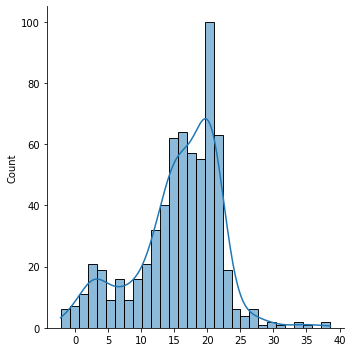

In [25]:
sns.displot(np.subtract(xgb_act,xgb_preds)[0],bins=30, kde=True)
plt.show()

Not a normal error distribution, has two modes.

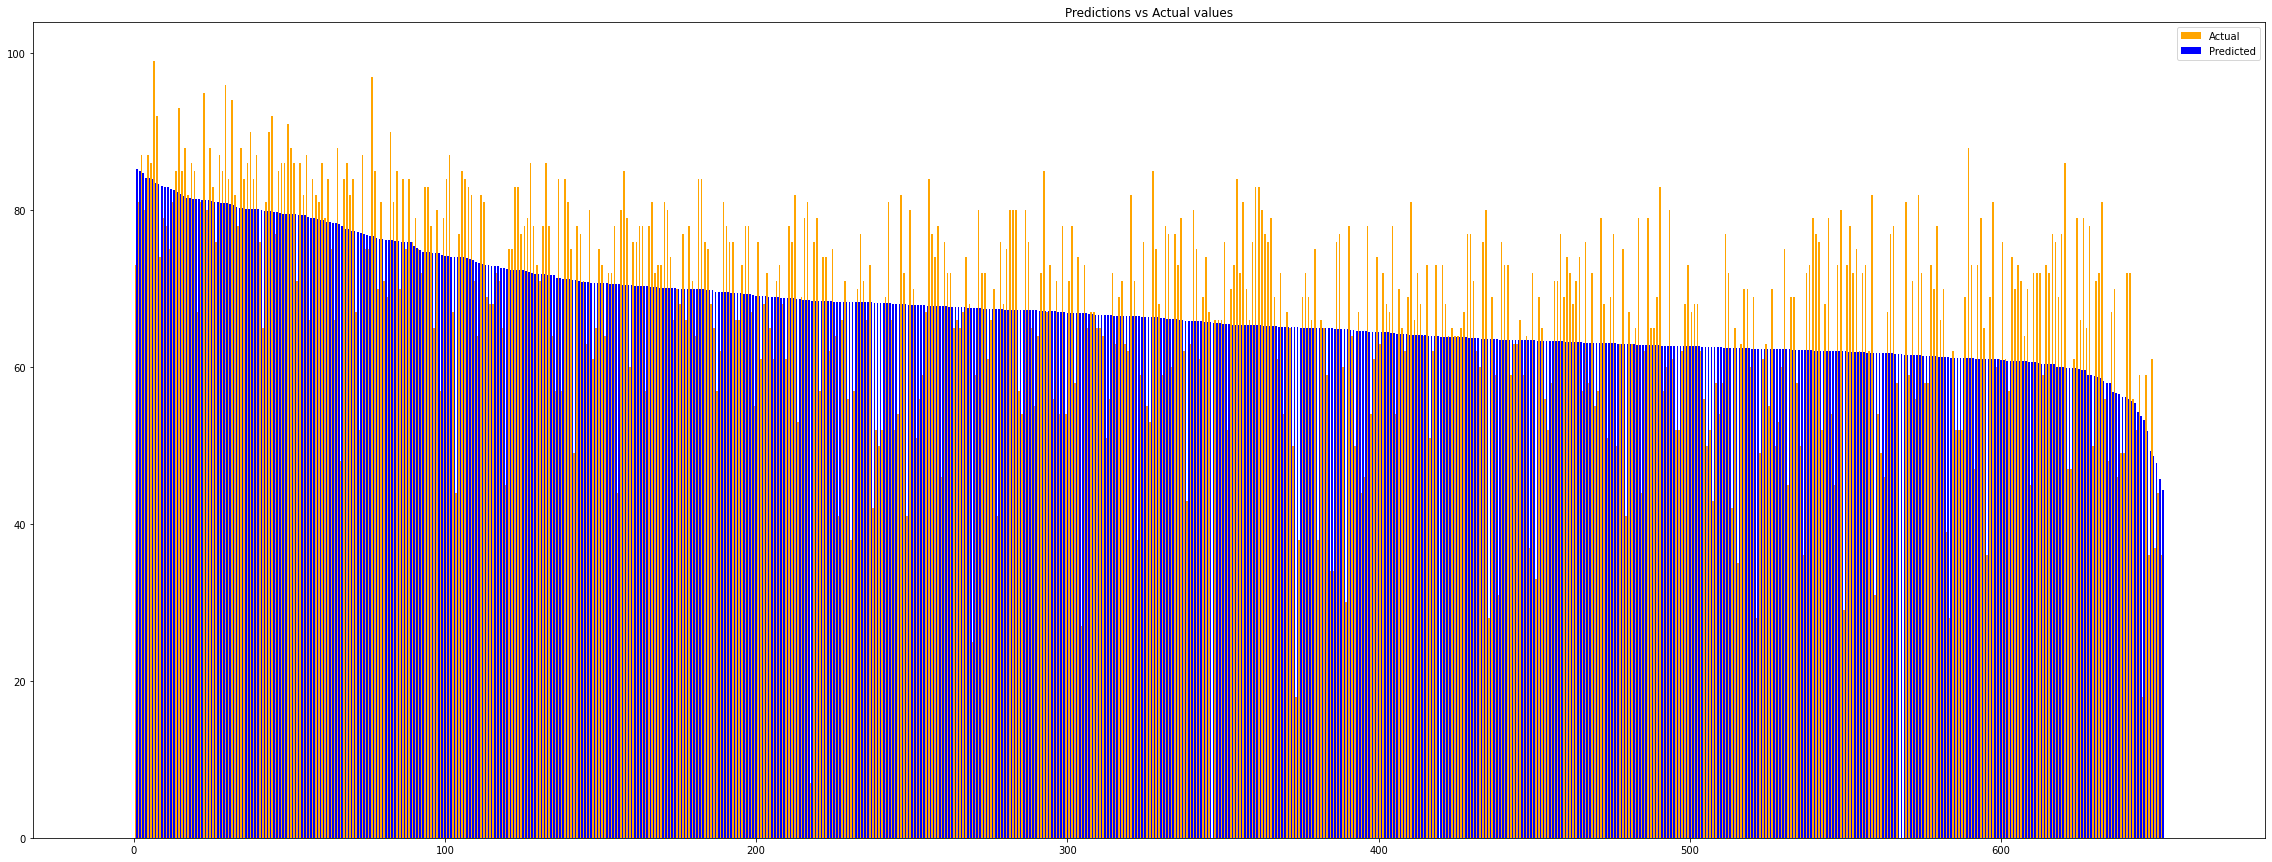

In [26]:
draw_error_distribution(np.subtract(xgb_act,xgb_preds)[0], xgb_preds, xgb_act)

The predictions are a bit better than svm and linear regression, but are still not good.

Draw feature importances for xgboost regressor.

In [28]:
xgb.fit(X, Y)

[15:50:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=3, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

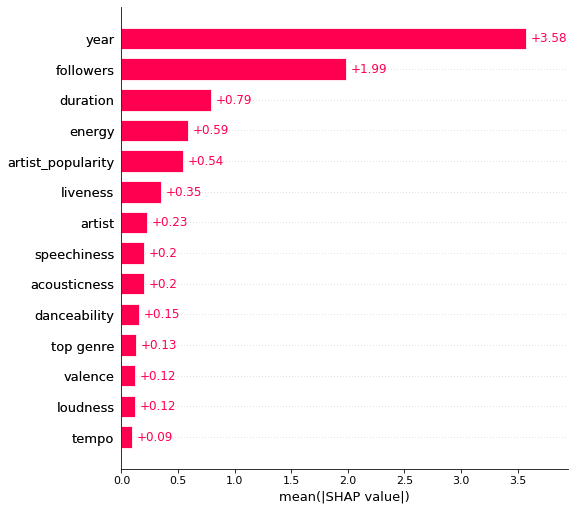

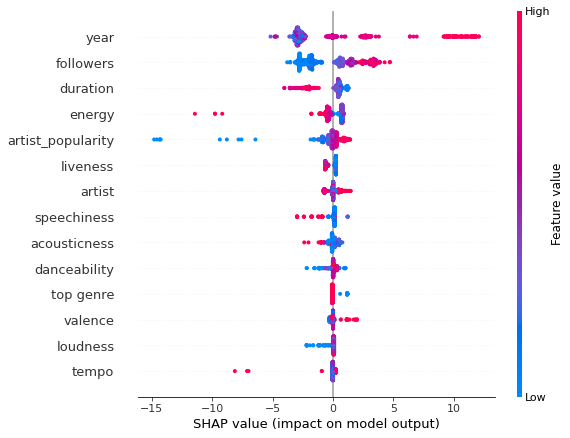

In [31]:
shap_graphs(xgb, X)

The shap beeswarm plot shows that songs in recent years are generally more popular than tracks made in the past, the more followers an artists has the more popular their songs are, longer songs contribute to predicting a lower popularity and shorter songs have a contribution towards predicting higher popularity. Less energic songs are predicted to be more popular, and more energic to be less popular, etc.

<h3>Artificial Neural Network</h3>

In [11]:
def cross_validation_network(X, Y, model, batch=8, ep=100):
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train, batch_size=batch, epochs=ep)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(list(Y_test.values))
  
  return predicted, actual

I am going to define one neural network with one hidden layer with 32 neurons and relu activation function. The output layer is going to have a linear activation with one neuron, since the target is continuous.

In [80]:
model = Sequential()
model.add(Dense(24, input_dim=len(X.columns), kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(1, kernel_initializer = 'uniform',activation='linear'))

In [81]:
opt = Adam(
    learning_rate = 0.001
)
model.compile(loss='mse', optimizer=opt, metrics='mse')

I am going to use adam optimizer since it has adaptive learning rates for each parameter and uses momentum to help solve the problem of saddle points. The loss function will be mean squared error. I am going to train with 150 epochs and 32 batch size.

In [83]:
pred_ann, actual_ann = cross_validation_network(X, Y, model, 32, 150)

Epoch 1/150
17/17 [==============================] - 0s 1ms/step - loss: 189.9621 - mse: 189.9621
Epoch 2/150
17/17 [==============================] - 0s 1ms/step - loss: 187.9906 - mse: 187.9906
Epoch 3/150
17/17 [==============================] - 0s 1ms/step - loss: 188.4902 - mse: 188.4902
Epoch 4/150
17/17 [==============================] - 0s 1ms/step - loss: 197.0589 - mse: 197.0589
Epoch 5/150
17/17 [==============================] - 0s 1ms/step - loss: 190.0747 - mse: 190.0747
Epoch 6/150
17/17 [==============================] - 0s 1ms/step - loss: 187.5871 - mse: 187.5871
Epoch 7/150
17/17 [==============================] - 0s 1ms/step - loss: 187.3533 - mse: 187.3533
Epoch 8/150
17/17 [==============================] - 0s 1ms/step - loss: 188.1214 - mse: 188.1214
Epoch 9/150
17/17 [==============================] - 0s 1ms/step - loss: 187.2365 - mse: 187.2365
Epoch 10/150
17/17 [==============================] - 0s 1ms/step - loss: 186.3125 - mse: 186.3125
Epoch 11/150
17/17 

In [84]:
print(f'----------------------')
print(f'Scores: ')
print(f'----------------------')
print(f'MSE: {mean_squared_error(actual_ann, pred_ann)}')
print(f'MAE: {mean_absolute_error(actual_ann, pred_ann)}')
print(f'R2 Score: {r2_score(actual_ann, pred_ann)}')

----------------------
Scores: 
----------------------
MSE: 185.97463175309466
MAE: 9.981996741031576
R2 Score: 0.10689715296459279


In [85]:
actual_ann = [val[0] for val in actual_ann]
pred_ann = [val[0] for val in pred_ann]

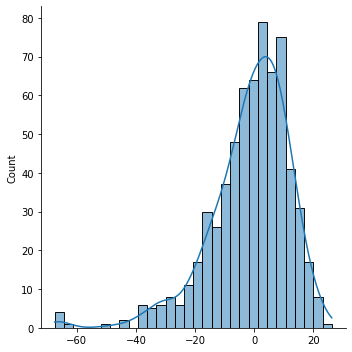

In [86]:
sns.displot(np.subtract(actual_ann, pred_ann),bins=30, kde=True)
plt.show()

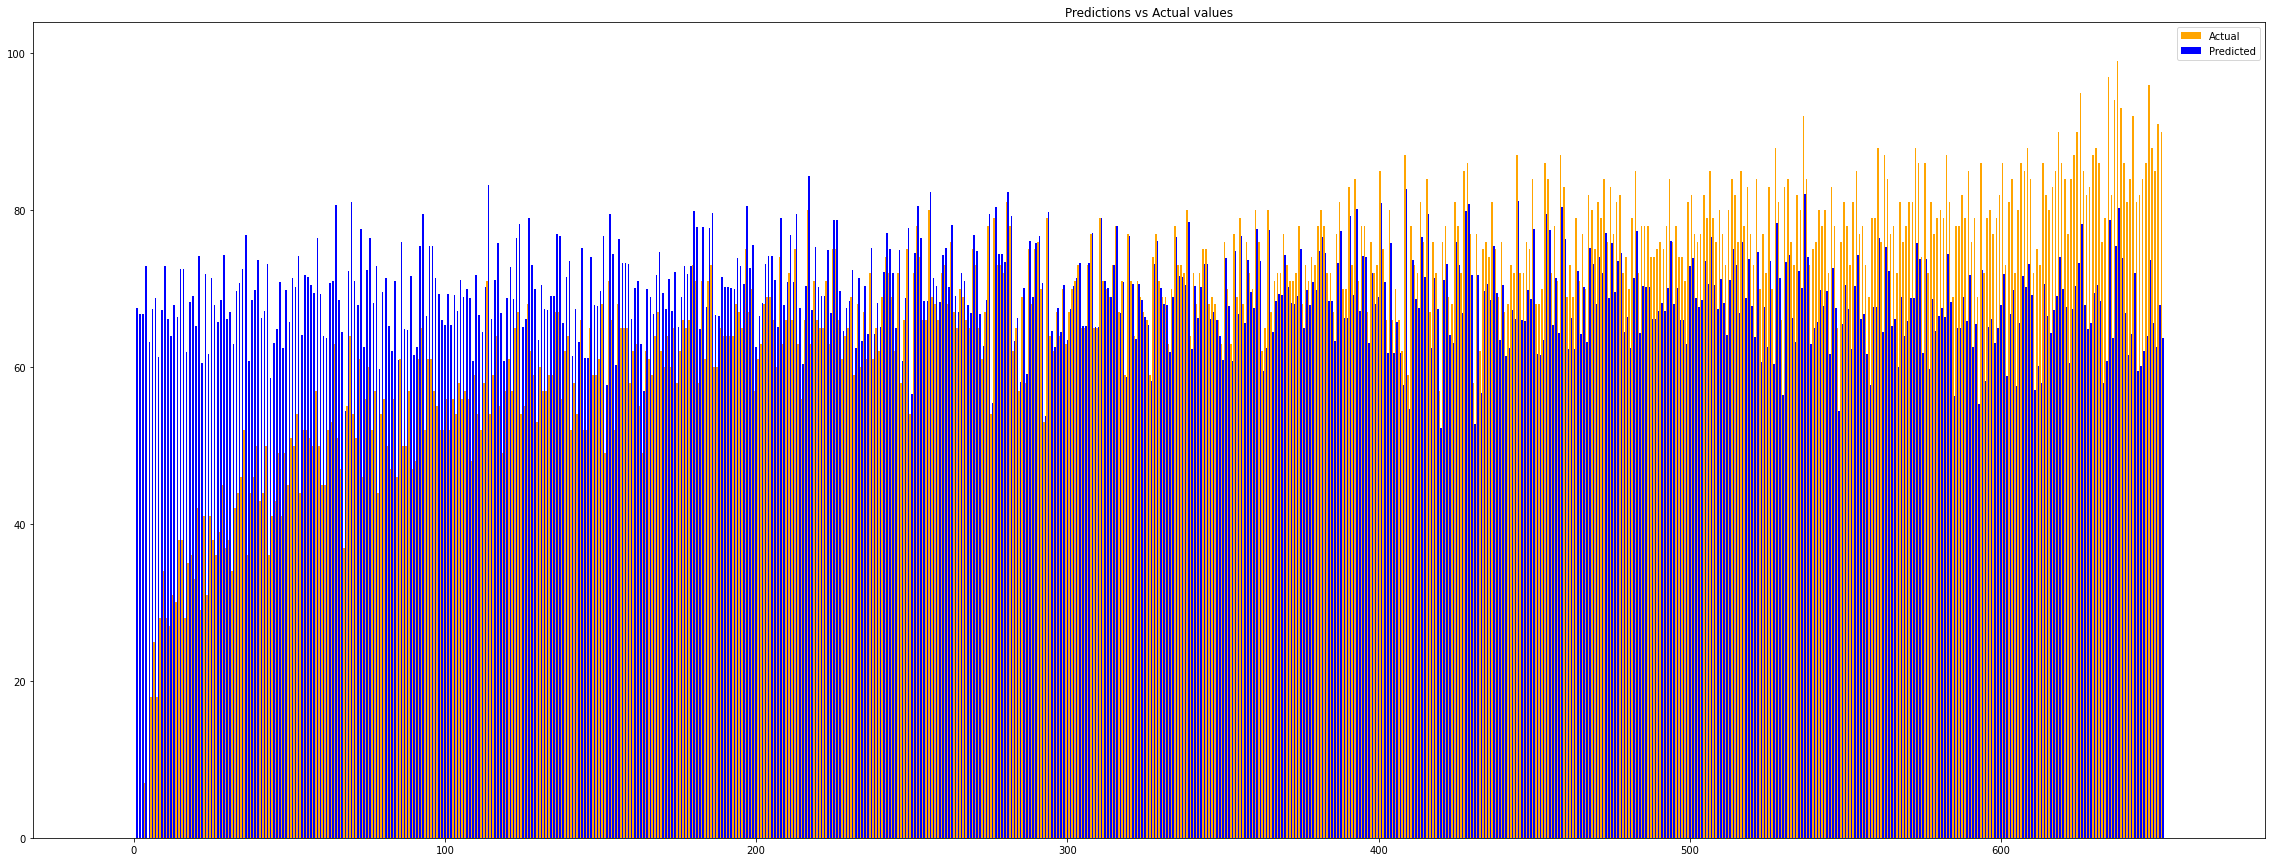

In [87]:
draw_error_distribution(np.subtract(actual_ann,pred_ann), pred_ann, actual_ann)

The error distribution is better than for the linear methods and xgboost, but it can still be improved. The next method will be deep learning. Error distribution is approximately normal with a mean of around 0 which is good.

<h3>Deep Neural Network</h3>

In [62]:
model = Sequential()
model.add(Dense(64, input_dim=len(X.columns), kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(32, kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(16, kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(8, kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(1, kernel_initializer = 'uniform',activation='linear'))

I am creating a deep network with 4 hidden layers with relu activation function with 64, 32, 16 and 8 neurons respectively. Also there is one output layer with linear activation since the target is continuous.

In [63]:
opt = Adam(
    learning_rate = 0.001
)
model.compile(loss='mse', optimizer=opt, metrics='mse')

I am going to use adam optimizer since it has adaptive learning rates for each parameter and uses momentum to help solve the problem of saddle points. The loss function will be mean squared error. I am going to train with 250 epochs and 32 batch size.

In [64]:
pred_ann, actual_ann = cross_validation_network(X, Y, model, 32, 250)

Epoch 1/250
17/17 [==============================] - 0s 2ms/step - loss: 4789.0454 - mse: 4789.0454
Epoch 2/250
17/17 [==============================] - 0s 2ms/step - loss: 4580.9624 - mse: 4580.9624
Epoch 3/250
17/17 [==============================] - 0s 2ms/step - loss: 2865.6460 - mse: 2865.6460
Epoch 4/250
17/17 [==============================] - 0s 2ms/step - loss: 354.9248 - mse: 354.9248
Epoch 5/250
17/17 [==============================] - 0s 2ms/step - loss: 238.0250 - mse: 238.0250
Epoch 6/250
17/17 [==============================] - 0s 2ms/step - loss: 207.7547 - mse: 207.7547
Epoch 7/250
17/17 [==============================] - 0s 2ms/step - loss: 200.5488 - mse: 200.5488
Epoch 8/250
17/17 [==============================] - 0s 2ms/step - loss: 203.2713 - mse: 203.2713
Epoch 9/250
17/17 [==============================] - 0s 2ms/step - loss: 199.8514 - mse: 199.8514
Epoch 10/250
17/17 [==============================] - 0s 2ms/step - loss: 200.3418 - mse: 200.3418
Epoch 11/250


In [65]:
print(f'----------------------')
print(f'Scores: ')
print(f'----------------------')
print(f'MSE: {mean_squared_error(actual_ann, pred_ann)}')
print(f'MAE: {mean_absolute_error(actual_ann, pred_ann)}')
print(f'R2 Score: {r2_score(actual_ann, pred_ann)}')

----------------------
Scores: 
----------------------
MSE: 186.7578065050674
MAE: 10.5284691734548
R2 Score: 0.10313612602172595


These scores are worse than for the neural network with one relu layer.

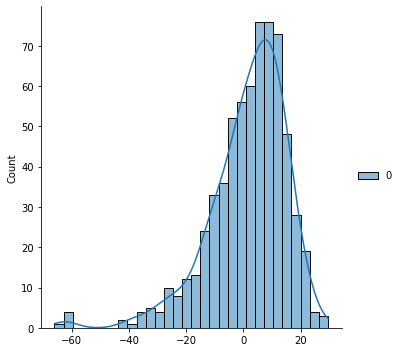

In [66]:
sns.displot(np.subtract(actual_ann, pred_ann),bins=30, kde=True)
plt.show()

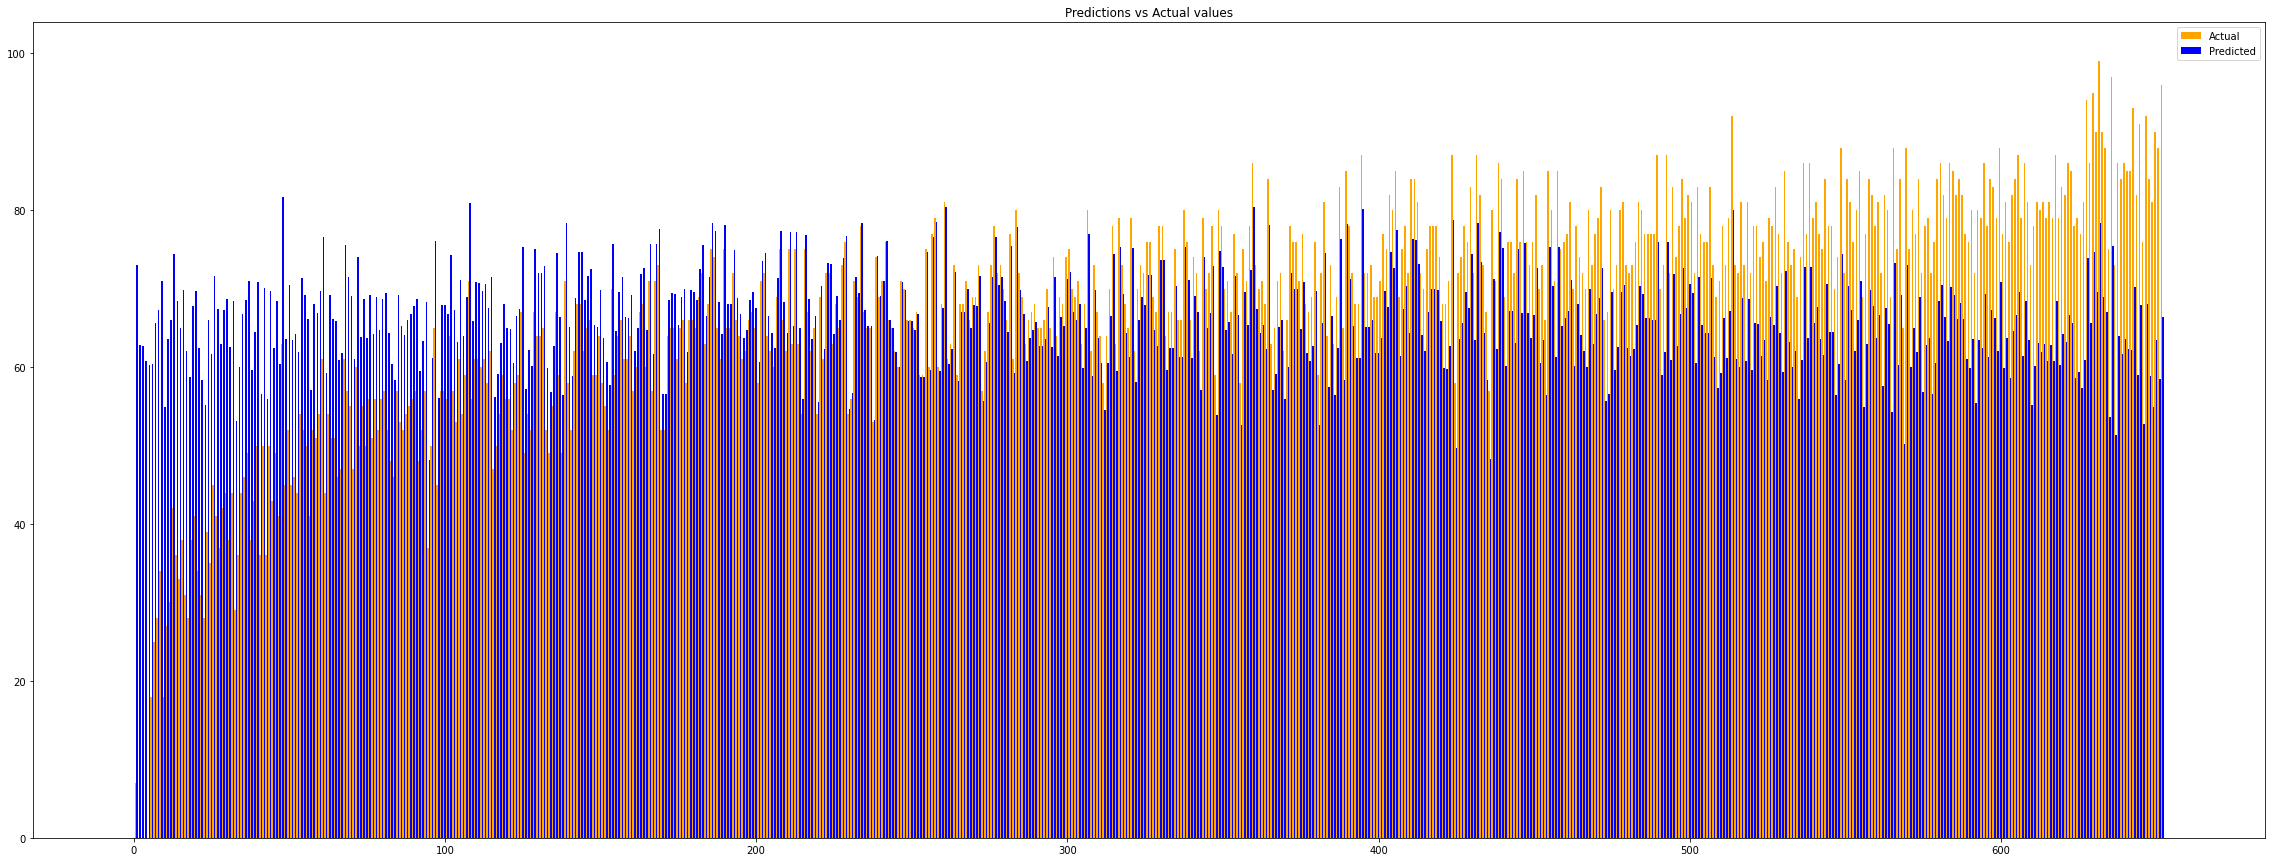

In [67]:
draw_error_distribution(np.subtract(actual_ann,pred_ann), pred_ann, actual_ann)

<b>Replacing relu with sigmoid in the hidden layer</b>

In [68]:
model = Sequential()
model.add(Dense(64, input_dim=len(X.columns), kernel_initializer = 'uniform', activation='sigmoid'))
model.add(Dense(32, kernel_initializer = 'uniform', activation='sigmoid'))
model.add(Dense(16, kernel_initializer = 'uniform', activation='sigmoid'))
model.add(Dense(8, kernel_initializer = 'uniform', activation='sigmoid'))
model.add(Dense(1, kernel_initializer = 'uniform',activation='linear'))

In [69]:
opt = Adam(
    learning_rate = 0.001
)
model.compile(loss='mse', optimizer=opt, metrics='mse')

In [70]:
pred_ann, actual_ann = cross_validation_network(X, Y, model, 32, 250)

Epoch 1/250
17/17 [==============================] - 0s 2ms/step - loss: 4798.9565 - mse: 4798.9565
Epoch 2/250
17/17 [==============================] - 0s 2ms/step - loss: 4786.3457 - mse: 4786.3457
Epoch 3/250
17/17 [==============================] - 0s 2ms/step - loss: 4772.3911 - mse: 4772.3911
Epoch 4/250
17/17 [==============================] - 0s 2ms/step - loss: 4755.4751 - mse: 4755.4751
Epoch 5/250
17/17 [==============================] - 0s 2ms/step - loss: 4734.5918 - mse: 4734.5918
Epoch 6/250
17/17 [==============================] - 0s 2ms/step - loss: 4710.5107 - mse: 4710.5107
Epoch 7/250
17/17 [==============================] - 0s 3ms/step - loss: 4684.3369 - mse: 4684.3369
Epoch 8/250
17/17 [==============================] - 0s 2ms/step - loss: 4656.8936 - mse: 4656.8936
Epoch 9/250
17/17 [==============================] - 0s 2ms/step - loss: 4629.3027 - mse: 4629.3027
Epoch 10/250
17/17 [==============================] - 0s 2ms/step - loss: 4602.1548 - mse: 4602.1548

In [71]:
print(f'----------------------')
print(f'Scores: ')
print(f'----------------------')
print(f'MSE: {mean_squared_error(actual_ann, pred_ann)}')
print(f'MAE: {mean_absolute_error(actual_ann, pred_ann)}')
print(f'R2 Score: {r2_score(actual_ann, pred_ann)}')

----------------------
Scores: 
----------------------
MSE: 428.2037468699273
MAE: 15.722001713477761
R2 Score: -1.0563556536489669


Apparently, using sigmoid produces worse results which is ususal in this kind of setting.

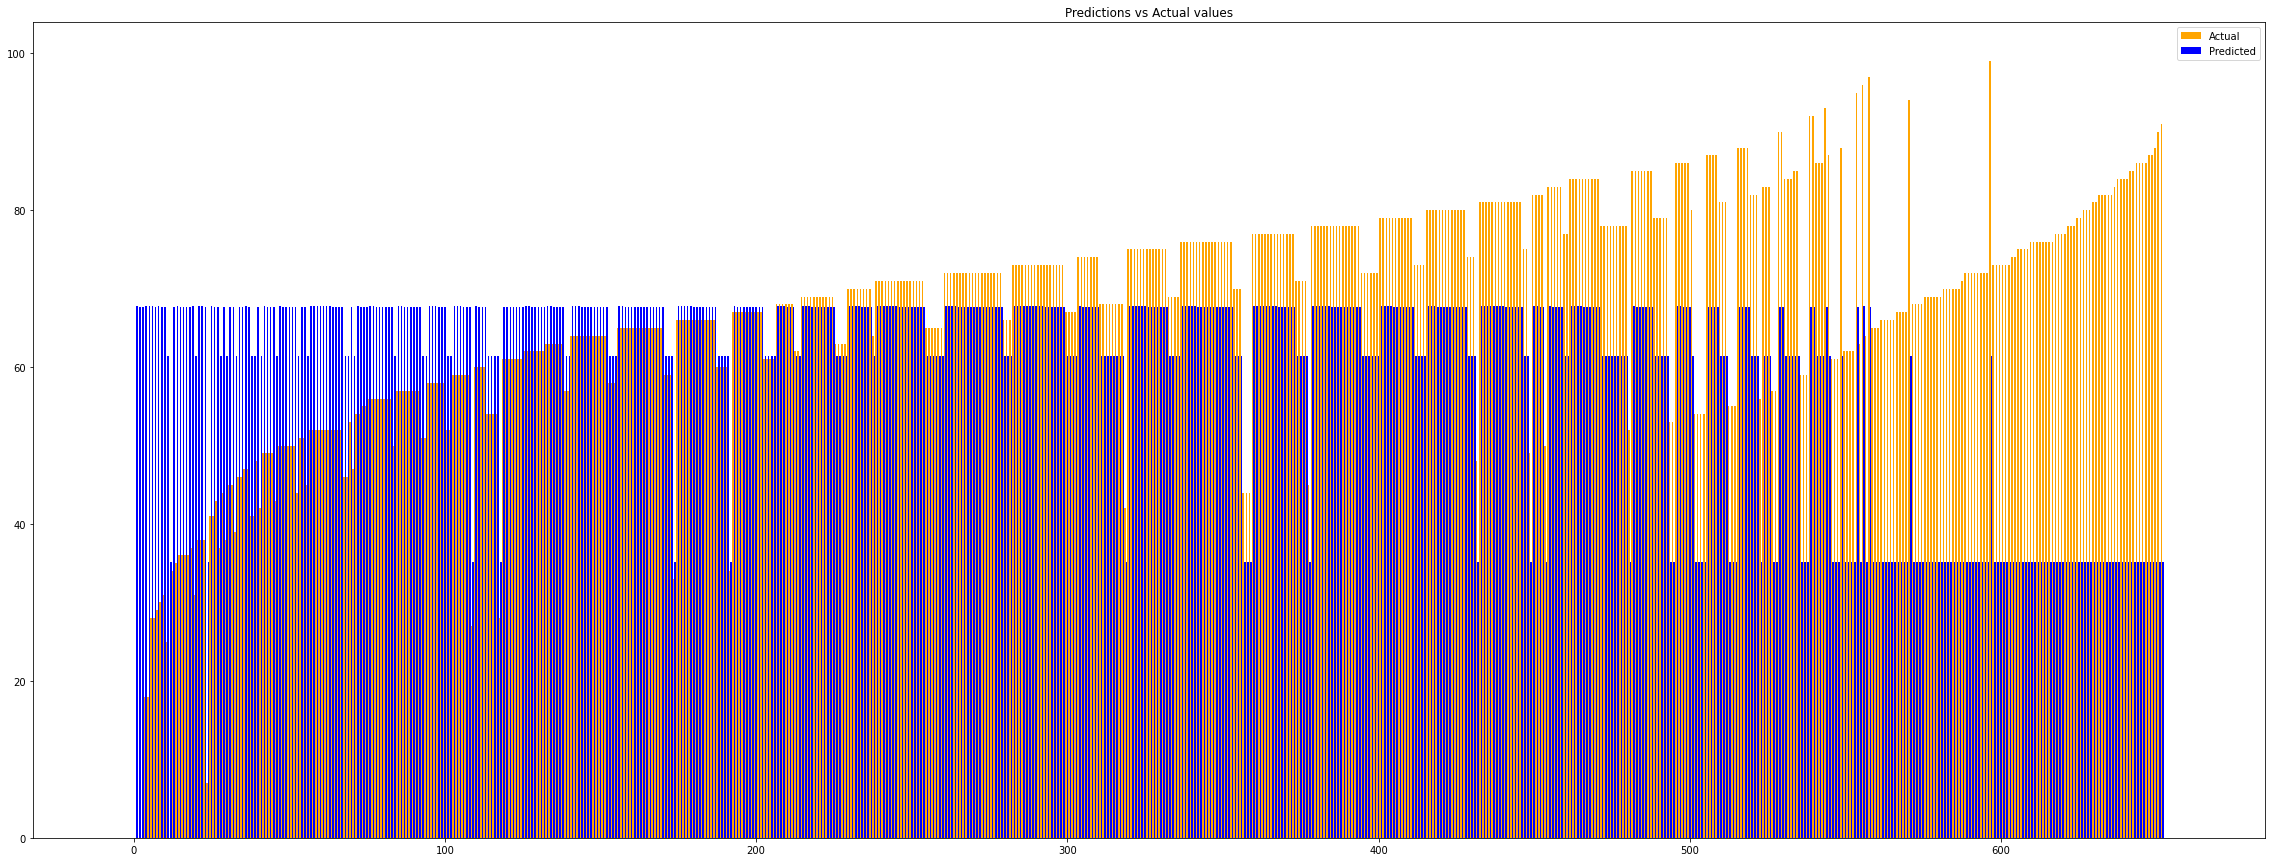

In [72]:
draw_error_distribution(np.subtract(actual_ann,pred_ann), pred_ann, actual_ann)

Best performance was achieved with the ann with one layer and relu activation function.

In conclusion, xgboost outperfomred the neural networks. This may be due to the small size of the data set. Generally, neural networks, especially deep networks need a lot of training data to produce promising results. But that was not the case with this data set that had only around 650 tracks.